## Cluster Analysis: Can the Prompts/Scores be inferred from the essays?
This notebook attempts to cluster the essays in such a way that essays with the same or similar prompt (essay question) or scores are grouped together.

## Approach
We chose to use a k-means model for clustering the essays. Our main goal is to ensure that the clustering process remains independent of any supervised models used to assign labels. By relying on an unsupervised approach, we avoid introducing bias from those external results.

We limit the number of clusters to either 30 — corresponding to the number of distinct prompts — or 10, which matches the number of score categories. We do not have a meaningful reference for selecting any other number of clusters.

## Key Findings
Using k-means clustering, it is not feasible to directly map clusters to the overall band scores of the essays. When utilizing TF-IDF vectors, an accuracy of up to 61% can be achieved, indicating a meaningful relationship between the prompts and the essays. Moreover, the results demonstrate that the embedding model's strong performance is not simply due to the prompt classes being derived from it. Data imbalance appears to pose a greater challenge for the TF-IDF vectors, as techniques like oversampling and PCA generally degraded the results.

In contrast, with the embedding model, the application of PCA and oversampling methods led to partial improvements. The optimal configuration combined Random Oversampling, the embedding model, and PCA with approximately 35 components, achieving around 81% accuracy on the training data and 78% accuracy on the test set.

## Imports und Setup
---

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from scipy.sparse import hstack
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import seaborn as sns

import umap

In [2]:
pd.options.plotting.backend = "plotly"

## Data Import
---

In [ ]:
df_train = pd.read_csv("../data/clean_clustered_train.csv")
df_test = pd.read_csv("../data/clean_clustered_test.csv")

In [5]:
df_train.describe()

,task_achievement_score,coherence_and_cohesion_score,lexical_resource_score,grammatical_range_and_accuracy_score,band_score,cluster
count,9048.000000,9048.000000,9048.000000,9048.000000,9048.000000,9048.000000
mean,6.122016,5.962588,5.664511,5.580018,6.247955,12.585102
std,1.387875,1.536109,1.436100,1.498869,1.225668,8.356636
min,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000
25%,5.500000,5.000000,5.000000,5.000000,5.500000,5.000000
50%,6.500000,6.000000,6.000000,6.000000,6.500000,11.000000
75%,7.000000,7.000000,6.500000,6.500000,7.000000,20.000000
max,9.000000,9.000000,8.500000,8.500000,8.500000,29.000000


In [20]:
essays_train = df_train["essay"]
score_train = df_train["band_score"]*10
cl_prompt_train = df_train["cluster"]

essays_test = df_test["essay"]
score_test = df_test["band_score"]*10
cl_prompt_test = df_test["cluster"]


## Basic statistics

---

Display the clusterd prompt distribution

(9048,)


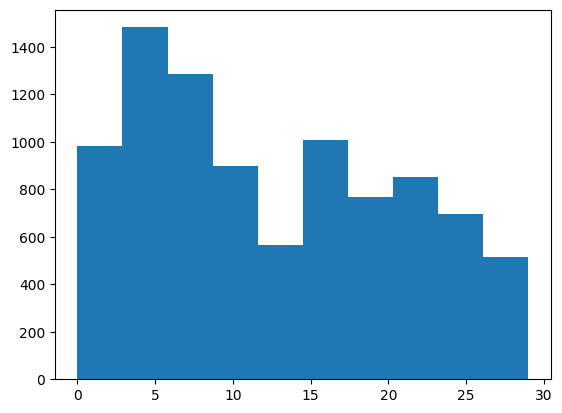

In [23]:
plt.hist(cl_prompt_train)
print(cl_prompt_train.shape)

Display the overall band score distribution

(9048,)


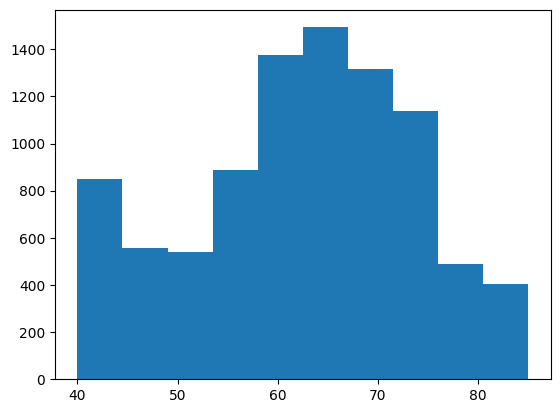

In [24]:
plt.hist(score_train)
print(score_train.shape)

## The essays are vectorized using both a TF-IDF vectorizer and a neural embedding model.

---

We use TF-IDF as a baseline to evaluate and compare the results against those produced by the embedding-based model.

In [25]:
prompt_vec = TfidfVectorizer(
    tokenizer=word_tokenize,
    lowercase=True,
    ngram_range=(1,3),
    min_df=2
)

essay_vec  = TfidfVectorizer(tokenizer=word_tokenize,
                             lowercase=True,
                             ngram_range=(1,3),
                             min_df=2)

In [26]:
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

tf_essay_train = essay_vec.fit_transform(essays_train)
print(tf_essay_train.shape)

tf_essay_test = essay_vec.transform(essays_test)
print(tf_essay_test.shape)

c:\Users\Sascha\Desktop\StudiumWin\4.Semester\NLP\Projekte\Team 10\team-10\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(9048, 597414)
(454, 597414)


In [27]:
emb_essay_train = np.load("../embeddings/embeddings_train_essays.npy")
print(emb_essay_train.shape)
emb_essay_test = np.load("../embeddings/embeddings_test_essays.npy")
print(emb_essay_test.shape)

(9048, 1024)
(454, 1024)


## Oversampling
---
Since the scores and the prompt clusters are imbalanced, we apply two different oversampling methods: SMOTE and Random Oversampling.
In order to compare both methods and to address the imbalance if needed.

### Random Oversampling

Clusterd prompts

In [29]:
ros_tf = RandomOverSampler(random_state=42)
tf_res_essay_train, cl_res_tf_prompt_train = ros_tf.fit_resample(
    tf_essay_train, cl_prompt_train
)
ros_emb = RandomOverSampler(random_state=42)
emb_res_essay_train, cl_res_emb_prompt_train = ros_emb.fit_resample(
    emb_essay_train, cl_prompt_train
)

Scores

In [32]:
ros_tf = RandomOverSampler(random_state=42)
tf_res_esscore_train, tf_score_train = ros_tf.fit_resample(
    tf_essay_train, score_train
)
ros_emb = RandomOverSampler(random_state=42)
emb_res_esscore_train, emb_score_train = ros_emb.fit_resample(
    emb_essay_train, score_train
)

### SMOTE

SMOTE is applied only to the TF-IDF vectors, since its effect on embedding representations is difficult to estimate or interpret.

In [34]:
tf_smote_train, tf_smote_cl_prompt_train = SMOTE().fit_resample(
    tf_essay_train, cl_prompt_train
)

In [33]:
tf_smotescore_train, tf_smote_score_train = SMOTE().fit_resample(
    tf_essay_train, score_train
)

## Utility functions

---

Because the cluster indices do not align with the true labels, a mapping is required to evaluate the model.

In [123]:
def map_clusters_to_labels(y_true, cluster_labels):
    labels = np.zeros_like(cluster_labels)
    for i in np.unique(cluster_labels):
        mask = cluster_labels == i
        labels[mask] = mode(y_true[mask], keepdims=True).mode[0]
    return labels

In [124]:
def quick_kmeans(X, n, hist = False):
    kmeans = KMeans(n_clusters=n,random_state=42)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)

    if(hist):
        plt.hist(y_kmeans)

    return kmeans, y_kmeans

In [125]:
def quick_eva(y_true, y_pred, conf_mat=False):
    mapped_preds = map_clusters_to_labels(y_true, y_pred)
    print("Clustering Accuracy:", accuracy_score(y_true, mapped_preds))
    if(conf_mat):
        # Confusion Matrix berechnen
        cm = confusion_matrix(y_true, mapped_preds)

        plt.figure(figsize=(10, 10))

        # Optional: Visualisierung mit seaborn
        ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5, linecolor='gray')

        for i in range(len(cm)):
            ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title("Confusion Matrix")
        plt.show()

    return mapped_preds

In [126]:
def kmeans_tuning(n_pca, x_emb, n_cluster):
    pca_temp = PCA(n_components=n_pca)
    pca_temp.fit(x_emb)

    pca_essay_temp = pca_temp.transform(x_emb)

    kmeans_temp = KMeans(n_clusters=n_cluster)
    kmeans_temp.fit(pca_essay_temp)
    return kmeans_temp.predict(pca_essay_temp), kmeans_temp

In the tuning method, an array of different numbers of PCA components is passed in. For each of these component counts, four k-means models are trained, and the accuracy on the training sets is calculated and recorded. At the end, the best model along with all parameters and a list of the collected accuracies is returned.

In [127]:
def tuning(n_pca_range,x_emb , y_label, n_cluster):
    n_pca = 0
    list_accuracy = []
    accuracy = 0
    obj_kmeans = None
    mapped_y = None
    for n in n_pca_range:
        for i in np.arange(4):
            pred_kmeans_tun, kmeans_temp = kmeans_tuning(n, x_emb, n_cluster)
            mapped_preds = map_clusters_to_labels(y_label, pred_kmeans_tun)
            acc_temp = accuracy_score(y_label, mapped_preds)
            list_accuracy.append(acc_temp)
            if(acc_temp > accuracy):
                n_pca = n
                accuracy = acc_temp
                obj_kmeans = kmeans_temp
                mapped_y = mapped_preds
    return n_pca, accuracy, obj_kmeans, list_accuracy, mapped_y

# We begin by training on the original (unmodified) data.
---

### TF-IDF

(KMeans(n_clusters=10, random_state=42),
 array([7, 9, 7, ..., 5, 2, 5], shape=(9048,), dtype=int32))

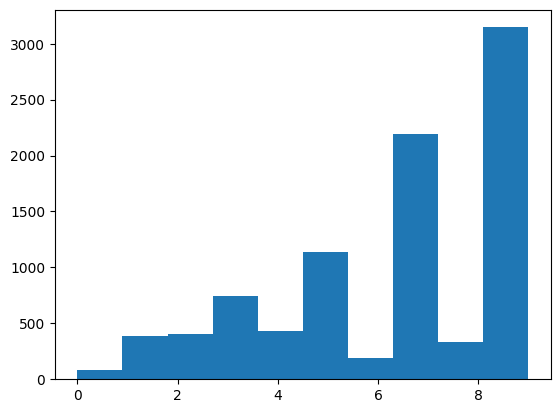

In [40]:
quick_kmeans(tf_essay_train, 10, True)

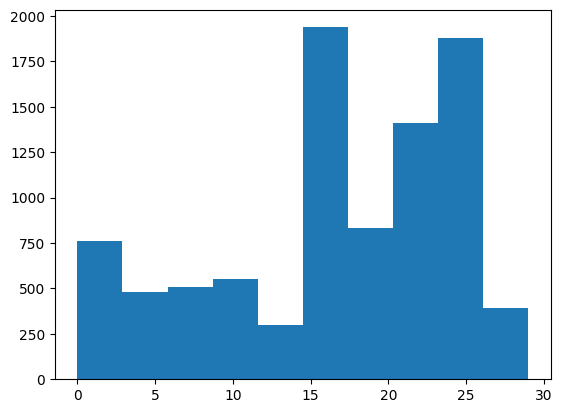

In [41]:
temp, y_pred_temp = quick_kmeans(tf_essay_train, 30, True)

The distribution of the 10 clusters, compared to the distribution of the scores, is too imbalanced for further analysis. In contrast, the distribution of the 30 clusters looks more promising, making it worthwhile to examine the confusion matrix in this case.

Clustering Accuracy: 0.6118479221927497


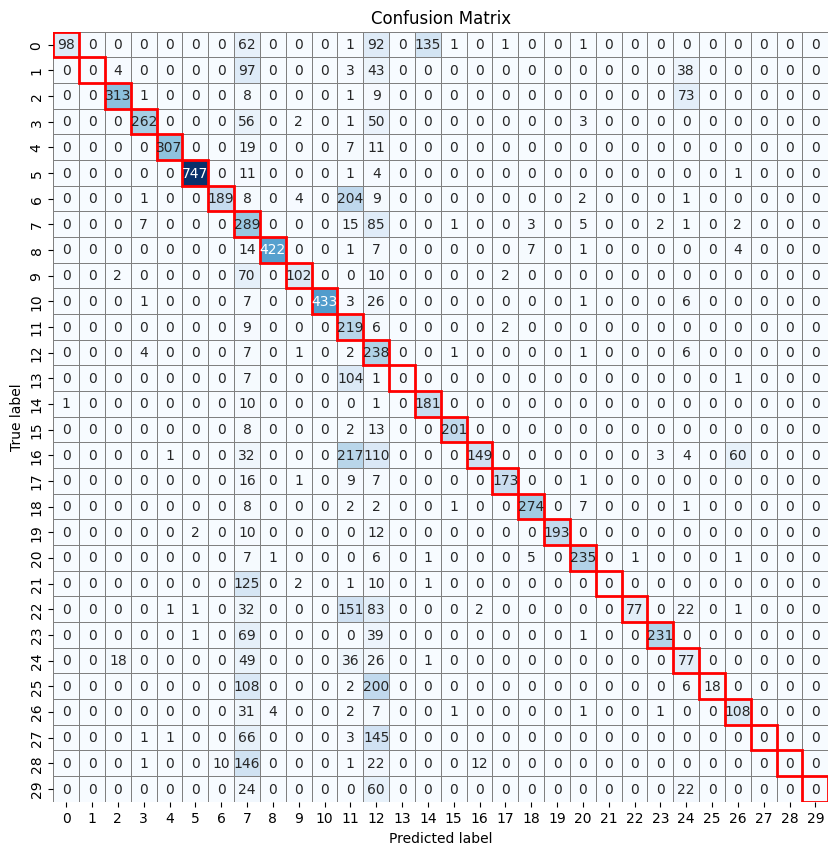

array([ 7, 12,  7, ...,  7,  2,  7], shape=(9048,), dtype=int32)

In [53]:
quick_eva(cl_prompt_train, y_pred_temp, True)

With ca. 61 percent accuracy, this is already a decent result for assigning essays to prompts. Classes 1, 7, 10, 12, 21, 27, 28 and 29 appear to be particularly problematic.

## Embedding Model

---

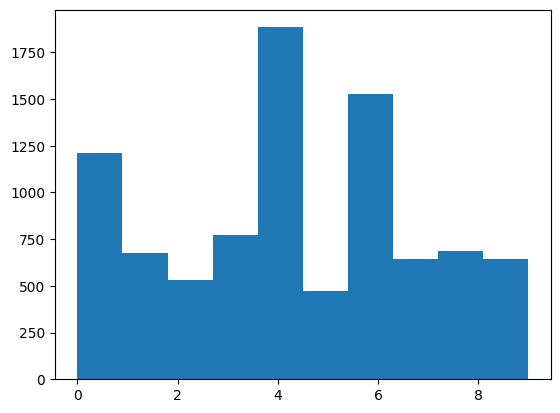

In [56]:
temp, y_pred_temp = quick_kmeans(emb_essay_train, 10, True)

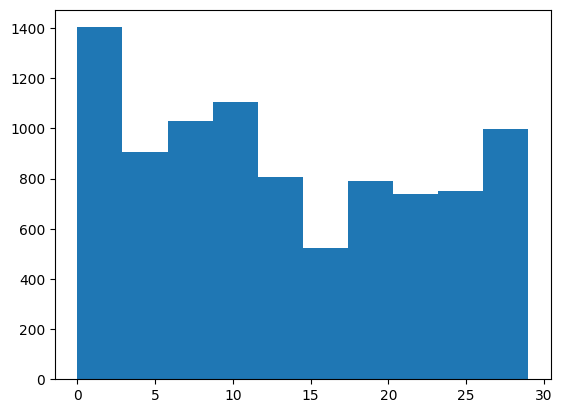

In [57]:
temp2, y_pred_temp2 = quick_kmeans(emb_essay_train, 30, True)

At this point, both distributions appear promising and suitable for more in-depth analysis.

Clustering Accuracy: 0.16799292661361626


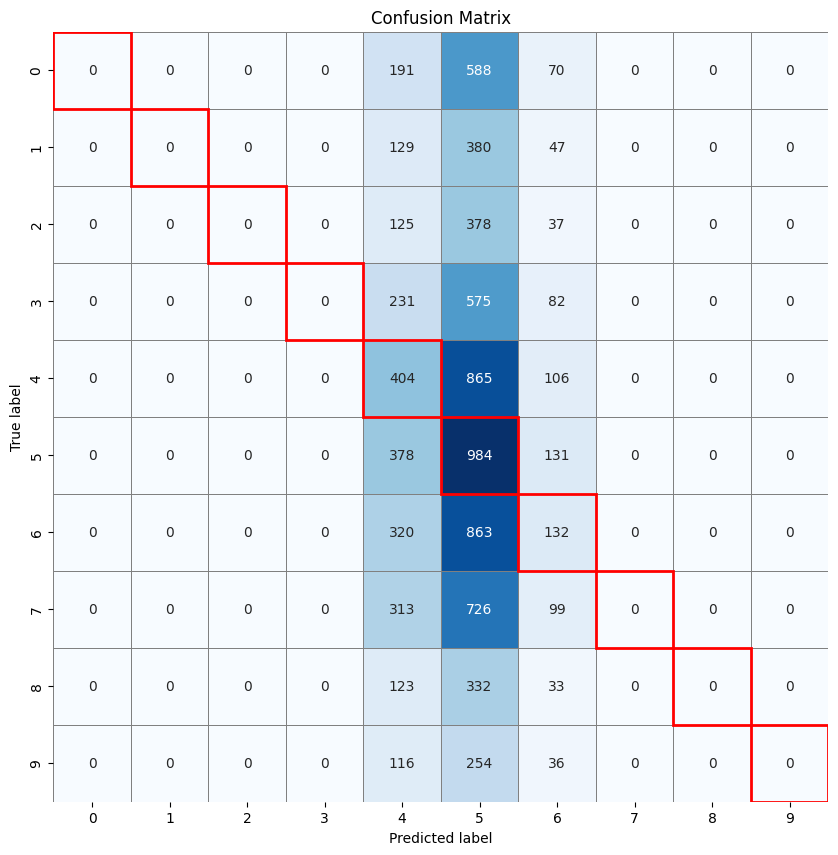

array([65, 65, 65, ..., 65, 65, 65], shape=(9048,), dtype=int32)

In [60]:
quick_eva(score_train, y_pred_temp, True)

Despite the similar distribution, the clustering appears to perform poorly in capturing the scores.

Clustering Accuracy: 0.7662466843501327


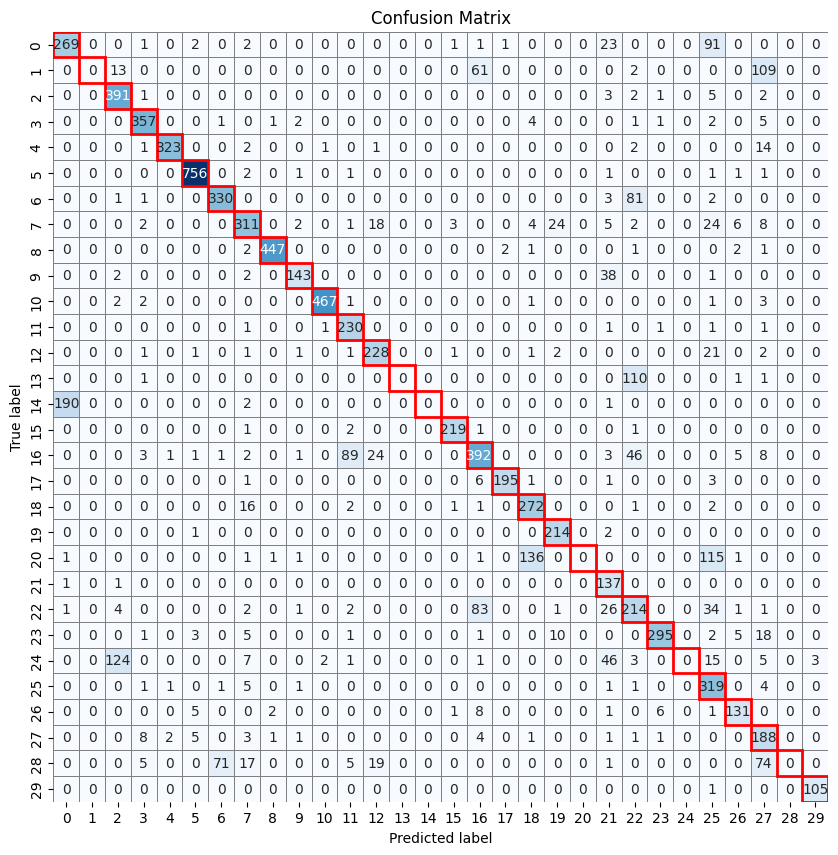

array([29, 29, 29, ...,  2,  2,  2], shape=(9048,), dtype=int32)

In [59]:
quick_eva(cl_prompt_train, y_pred_temp2, True)

At about 76%, our result seems to be clearly much better. However, classes 1, 13, 14, 20, 24 and 28 are not detected at all. The number of undetected classes is smaller than with the TF-IDF vectors.

## PCA

---

### TF-IDF

Dimension: 50
Accuracy:  0.16954022988505746


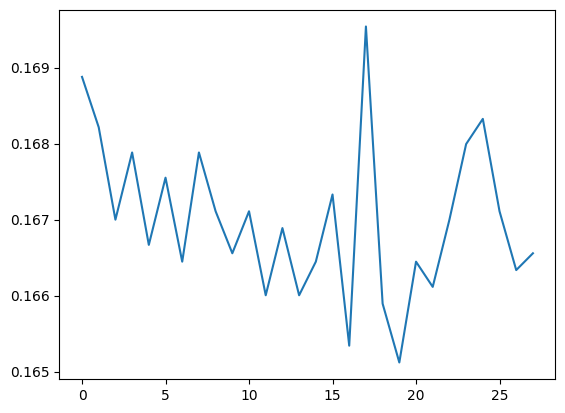

In [ ]:
dimensions = [5, 10, 20, 35, 50, 65, 80]
n_tun_temp, acc_tun_temp, kmeans_tun_temp, acc_list_temp, mapped_y_temp = tuning(dimensions, tf_essay_train, score_train, 10)
print("Dimension: " + str(n_tun_temp))
print("Accuracy:  " + str(acc_tun_temp))
plt.plot(acc_list_temp)
plt.xlabel("Trainings")
plt.ylabel("Accuracy")
plt.show()

PCA does not appear to enhance the clustering performance in relation to the scores.

Dimension: 35
Accuracy:  0.6521883289124668


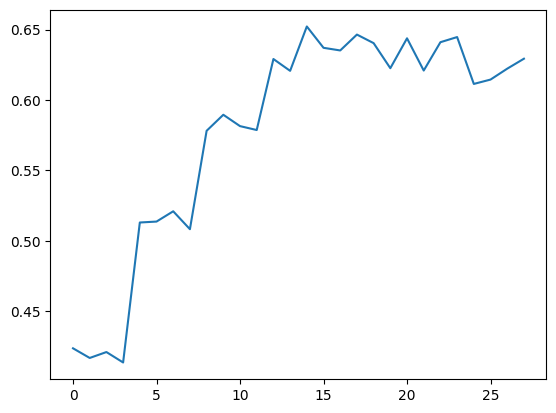

In [70]:
dimensions = [5, 10, 20, 35, 50, 65, 80]
n_tun_temp, acc_tun_temp, kmeans_tun_temp, acc_list_temp, mapped_y_temp = tuning(dimensions, tf_essay_train, cl_prompt_train, 30)
print("Dimension: " + str(n_tun_temp))
print("Accuracy:  " + str(acc_tun_temp))
plt.plot(acc_list_temp)
plt.xlabel("Trainings")
plt.ylabel("Accuracy")
plt.show()

Dimension: 100
Accuracy:  0.6398099027409372


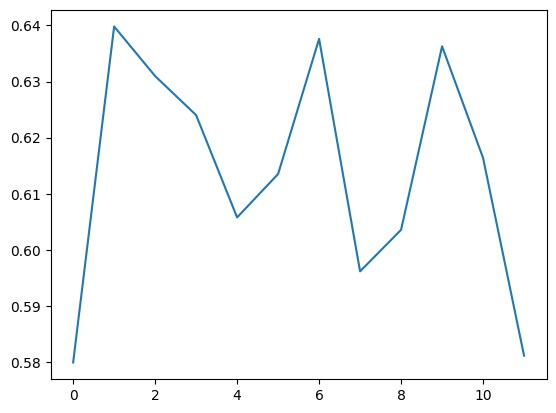

In [71]:
dimensions = [100, 120, 140 ]
n_tun_temp, acc_tun_temp, kmeans_tun_temp, acc_list_temp, mapped_y_temp = tuning(dimensions, tf_essay_train, cl_prompt_train, 30)
print("Dimension: " + str(n_tun_temp))
print("Accuracy:  " + str(acc_tun_temp))
plt.plot(acc_list_temp)
plt.xlabel("Trainings")
plt.ylabel("Accuracy")
plt.show()

PCA seems to have a negative impact on the results.

Dimension: 5
Accuracy:  0.16954022988505746


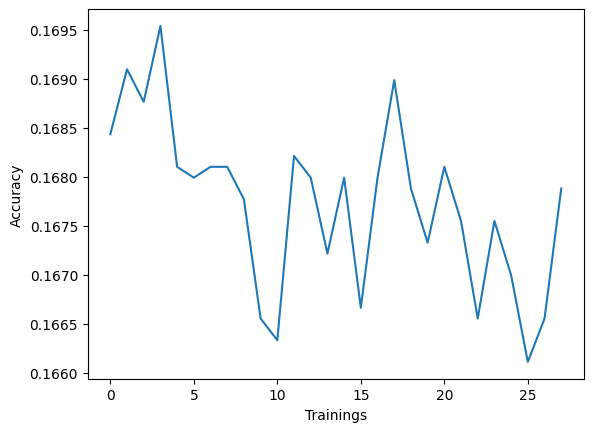

In [72]:
dimensions = [5, 10, 20, 35, 50, 65, 80]
n_tun_temp, acc_tun_temp, kmeans_tun_temp, acc_list_temp, mapped_y_temp = tuning(dimensions, emb_essay_train, score_train, 10)
print("Dimension: " + str(n_tun_temp))
print("Accuracy:  " + str(acc_tun_temp))
plt.plot(acc_list_temp)
plt.xlabel("Trainings")
plt.ylabel("Accuracy")
plt.show()

PCA does not appear to enhance the clustering performance in relation to the scores.

Dimension: 35
Accuracy:  0.7905614500442086


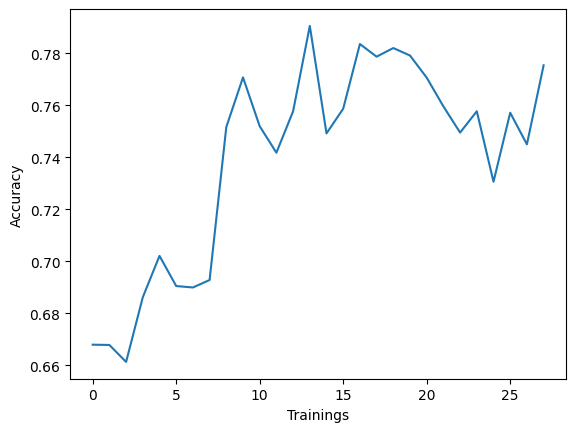

In [73]:
dimensions = [5, 10, 20, 35, 50, 65, 80]
n_tun_temp, acc_tun_temp, kmeans_tun_temp, acc_list_temp, mapped_y_temp = tuning(dimensions, emb_essay_train, cl_prompt_train, 30)
print("Dimension: " + str(n_tun_temp))
print("Accuracy:  " + str(acc_tun_temp))
plt.plot(acc_list_temp)
plt.xlabel("Trainings")
plt.ylabel("Accuracy")
plt.show()

Dimension: 100
Accuracy:  0.7863616268788682


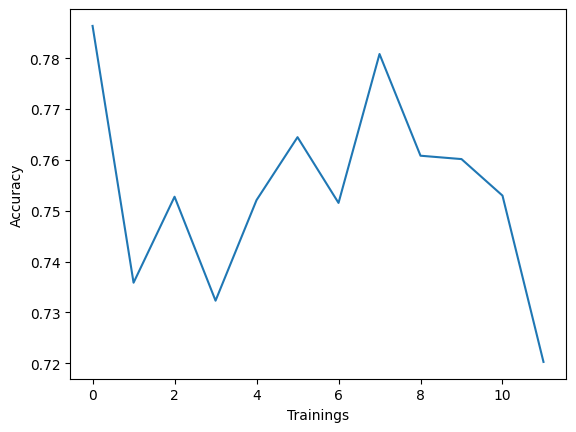

In [74]:
dimensions = [100, 120, 140]
n_tun_temp, acc_tun_temp, kmeans_tun_temp, acc_list_temp, mapped_y_temp = tuning(dimensions, emb_essay_train, cl_prompt_train, 30)
print("Dimension: " + str(n_tun_temp))
print("Accuracy:  " + str(acc_tun_temp))
plt.plot(acc_list_temp)
plt.xlabel("Trainings")
plt.ylabel("Accuracy")
plt.show()

Clustering Accuracy: 0.7863616268788682


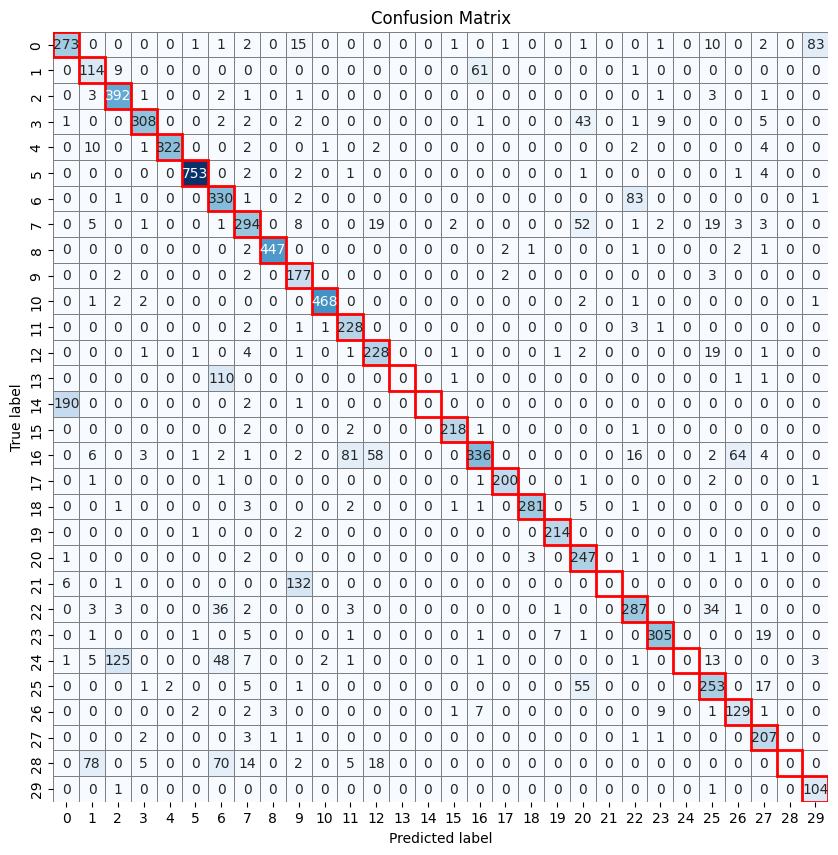

array([29, 29, 29, ...,  1,  2,  1], shape=(9048,), dtype=int32)

In [76]:
quick_eva(cl_prompt_train, mapped_y_temp, True)

In the case of the embedding model, PCA seems to have resulted in a slight improvement. Moreover, the number of classes that remain undetected has slightly decreased — now limited to classes 13, 14, 24, and 28.

## Oversampling
---

### SMOTE + TF-IDF

In [79]:
model_temp, y_pred_temp = quick_kmeans(tf_smotescore_train, 10)

Clustering Accuracy: 0.12049564634963161


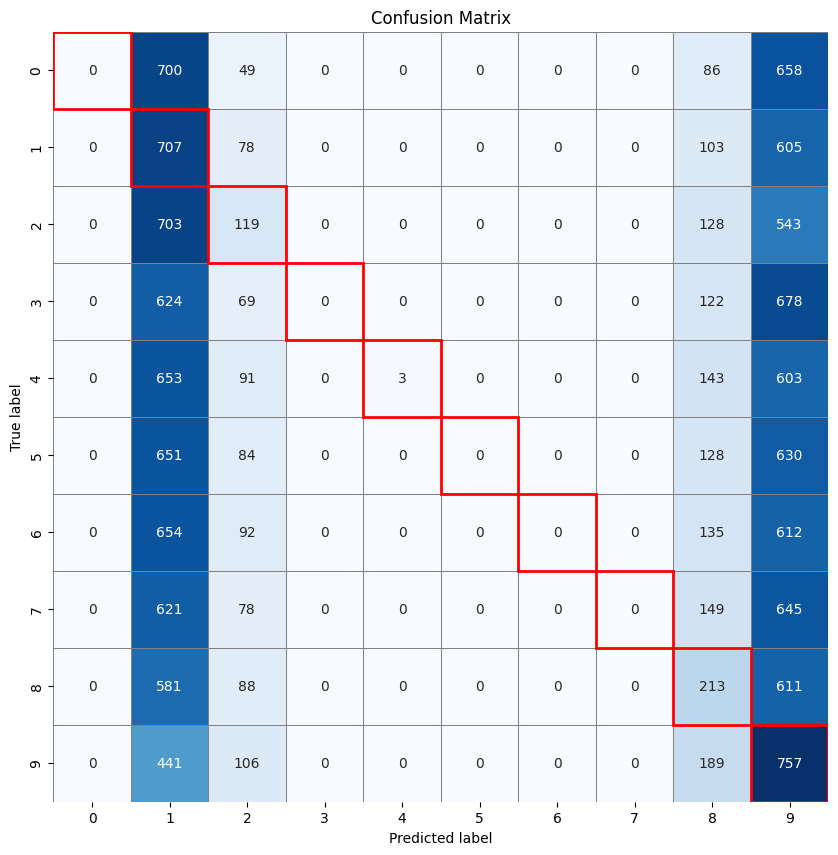

array([85, 45, 85, ..., 80, 80, 85], shape=(14930,), dtype=int32)

In [81]:
quick_eva(tf_smote_score_train, y_pred_temp, True)

In [82]:
model_temp, y_pred_temp = quick_kmeans(tf_smote_train, 30)

Clustering Accuracy: 0.462478184991274


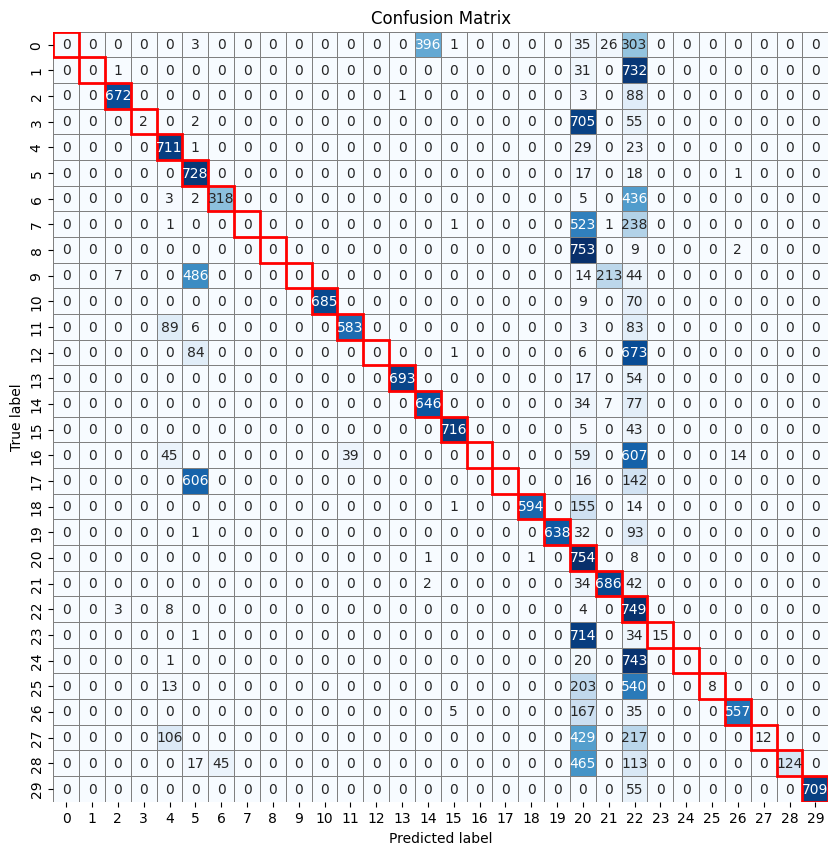

array([29, 29, 29, ..., 29, 22, 29], shape=(22920,), dtype=int32)

In [83]:
quick_eva(tf_smote_cl_prompt_train, y_pred_temp, True)

Applying SMOTE oversampling seems to have a negative impact on the results.

## Random Oversampling + TF-IDF

---

In [84]:
model_temp, y_pred_temp = quick_kmeans(tf_res_esscore_train, 10)

Clustering Accuracy: 0.1218352310783657


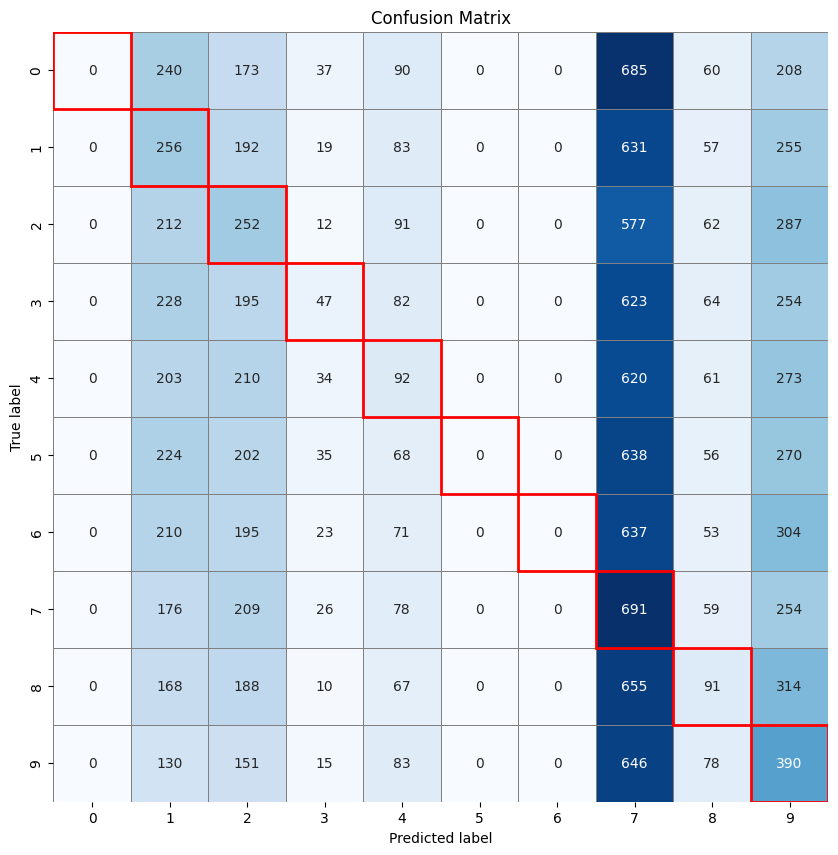

array([75, 50, 75, ..., 75, 75, 75], shape=(14930,), dtype=int32)

In [85]:
quick_eva(tf_score_train, y_pred_temp, True)

In [86]:
model_temp, y_pred_temp = quick_kmeans(tf_res_essay_train, 30)

Clustering Accuracy: 0.6069371727748691


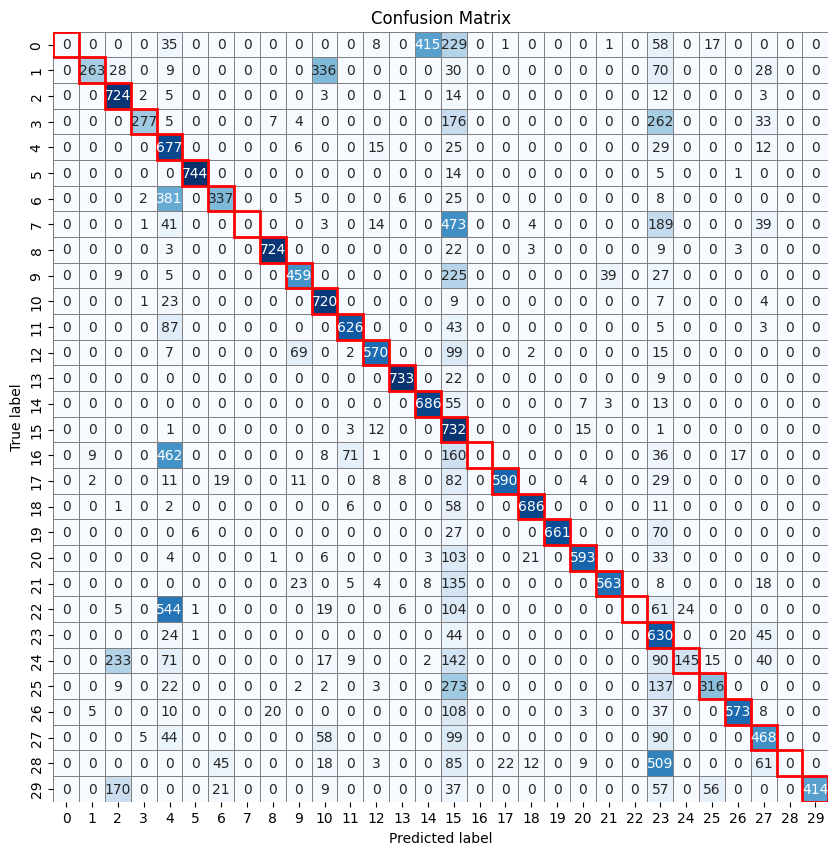

array([29, 15, 29, ...,  6, 29, 29], shape=(22920,), dtype=int32)

In [87]:
quick_eva(cl_res_tf_prompt_train, y_pred_temp, True)

Random oversampling likewise does not seem to enhance the results.

## Random Oversampling + Embedding modell

---

In [88]:
model_temp, y_pred_temp = quick_kmeans(emb_res_esscore_train, 10)

Clustering Accuracy: 0.12304085733422639


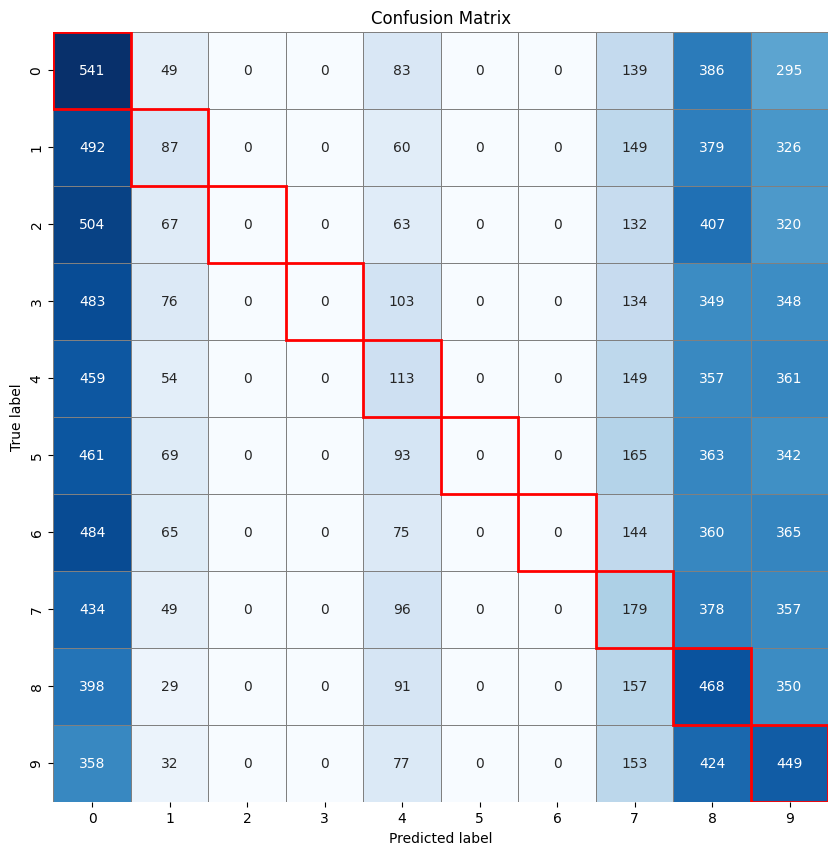

array([40, 40, 40, ..., 80, 85, 85], shape=(14930,), dtype=int32)

In [89]:
quick_eva(emb_score_train, y_pred_temp, True)

Clustering performance with respect to scores does not seem to benefit from random oversampling.
Capturing the score distribution through clustering appears to be ineffective when using k-means.

In [90]:
model_temp, y_pred_temp = quick_kmeans(emb_res_essay_train, 30)

Clustering Accuracy: 0.724432809773124


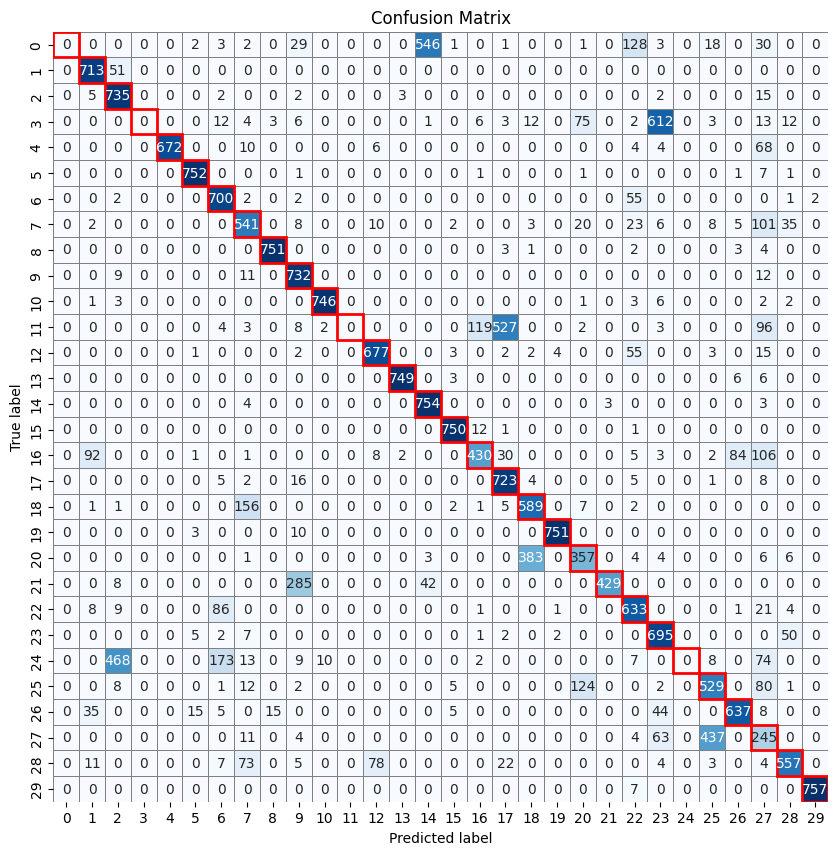

array([29, 29, 29, ..., 29, 29, 29], shape=(22920,), dtype=int32)

In [91]:
quick_eva(cl_res_emb_prompt_train, y_pred_temp, True)

Although random oversampling with the embedding model does not improve accuracy, it does reduce the number of undetected clusters to 0, 3, 11, and 24. Since these differ in part from the clusters missed with PCA, combining both methods could be a promising strategy.

## PCA + Random Oversampling + Embedding model

---

Dimension: 35
Accuracy:  0.8115619546247819


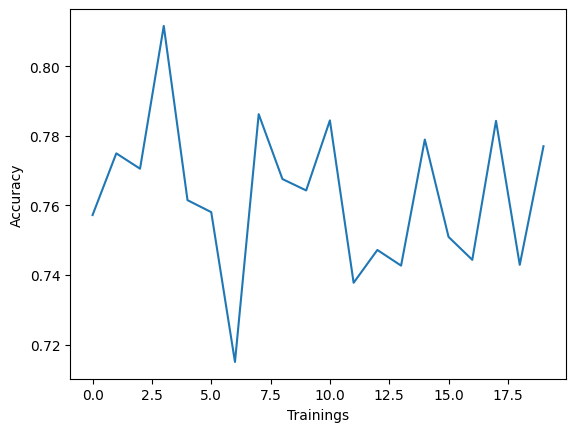

In [92]:
dimensions = [35, 50, 65, 80, 100]
n_tun_temp, acc_tun_temp, kmeans_tun_temp, acc_list_temp, mapped_y_temp = tuning(dimensions, emb_res_essay_train, cl_res_emb_prompt_train, 30)
print("Dimension: " + str(n_tun_temp))
print("Accuracy:  " + str(acc_tun_temp))
plt.plot(acc_list_temp)
plt.xlabel("Trainings")
plt.ylabel("Accuracy")
plt.show()

Clustering Accuracy: 0.8115619546247819


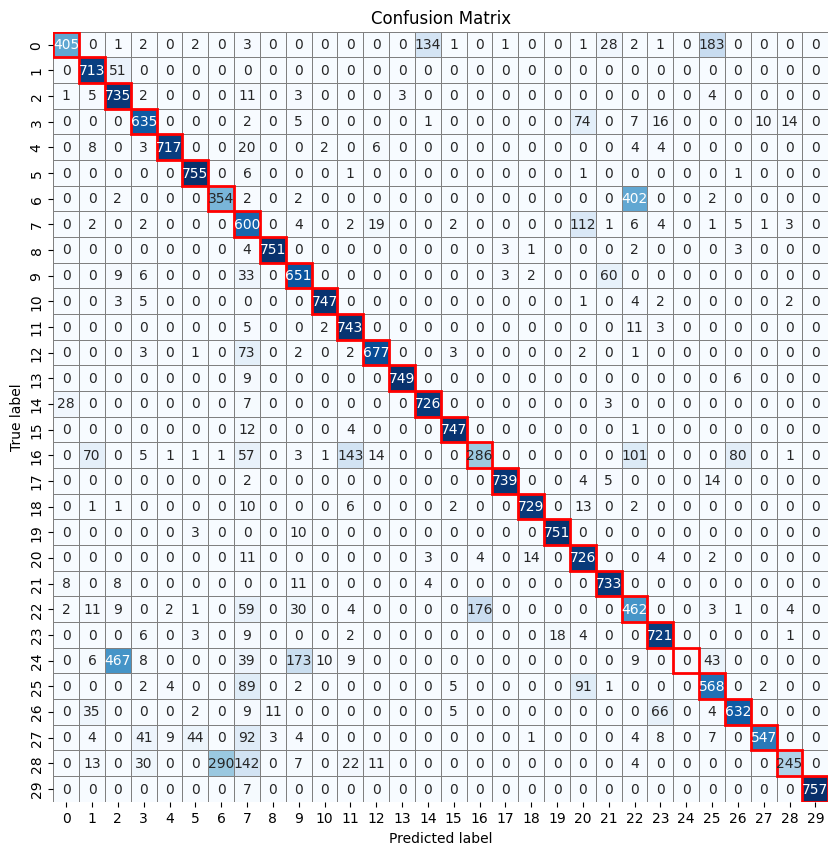

array([29, 29, 29, ..., 29, 29, 29], shape=(22920,), dtype=int32)

In [93]:
quick_eva(cl_res_emb_prompt_train, mapped_y_temp, True)

The combination of random oversampling, the embedding model, and PCA with 35 components seems to yield the best results so far, achieving an accuracy of around 81%. Additionally, only one class—24—remains undetected.

## Test

---

Clustering Accuracy: 0.7863436123348018


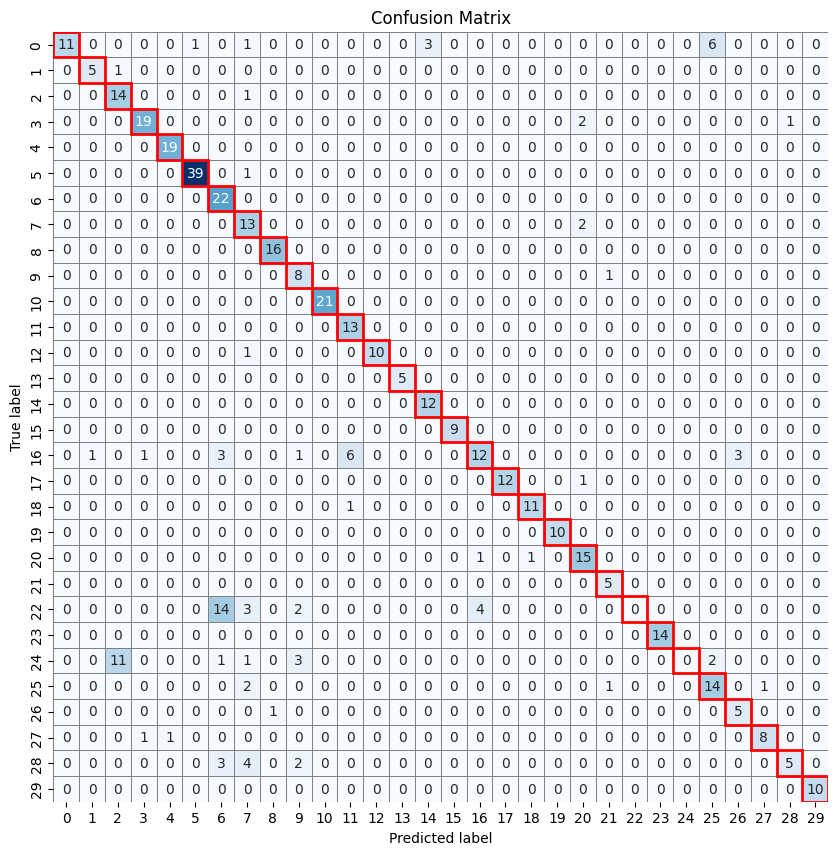

In [98]:
pca_temp = PCA(n_components=n_tun_temp)
pca_temp.fit(emb_res_essay_train)
pca_essay_test = pca_temp.transform(emb_essay_test)

y_test_pred = kmeans_tun_temp.predict(pca_essay_test)
a = quick_eva(cl_prompt_test, y_test_pred, True)

When evaluating the model on the test sample, an accuracy of 78% is achieved, which is close to the training accuracy. The issue with class 24 appears to persist during testing. However, the problem with class 22 seems to reoccur in the test set, even though it was resolved during training.

## Visualization
---
PCA could be used to visualize the clusters, but it tends to perform poorly when reducing to low dimensions. For this reason, we opt for UMAP, which, unlike PCA, is a nonlinear method.

In [99]:
import umap 
umap_emb_ro = umap.UMAP()
umap_emb_ro.fit(emb_res_essay_train)

c:\Users\Sascha\Desktop\StudiumWin\4.Semester\NLP\Projekte\Team 10\team-10\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Sascha\Desktop\StudiumWin\4.Semester\NLP\Projekte\Team 10\team-10\.venv\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\Sascha\Desktop\StudiumWin\4.Semester\NLP\Projekte\Team 10\team-10\.venv\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\Sascha\Desktop\StudiumWin\4.Semester\NLP\Projekte\Team 

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [101]:
umap_X_train = umap_emb_ro.transform(emb_res_essay_train)

c:\Users\Sascha\Desktop\StudiumWin\4.Semester\NLP\Projekte\Team 10\team-10\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [116]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import colorsys

# Anzahl der Klassen
num_classes = 30

# Farbpalette erzeugen (z.B. 30 verschiedene Farben im HSV-Farbraum)
def get_n_distinct_colors(n):
    HSV_tuples = [(x*1.0/n, 0.5, 0.8) for x in range(n)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    return RGB_tuples

colors_30 = get_n_distinct_colors(num_classes)
cmap_30 = ListedColormap(colors_30)

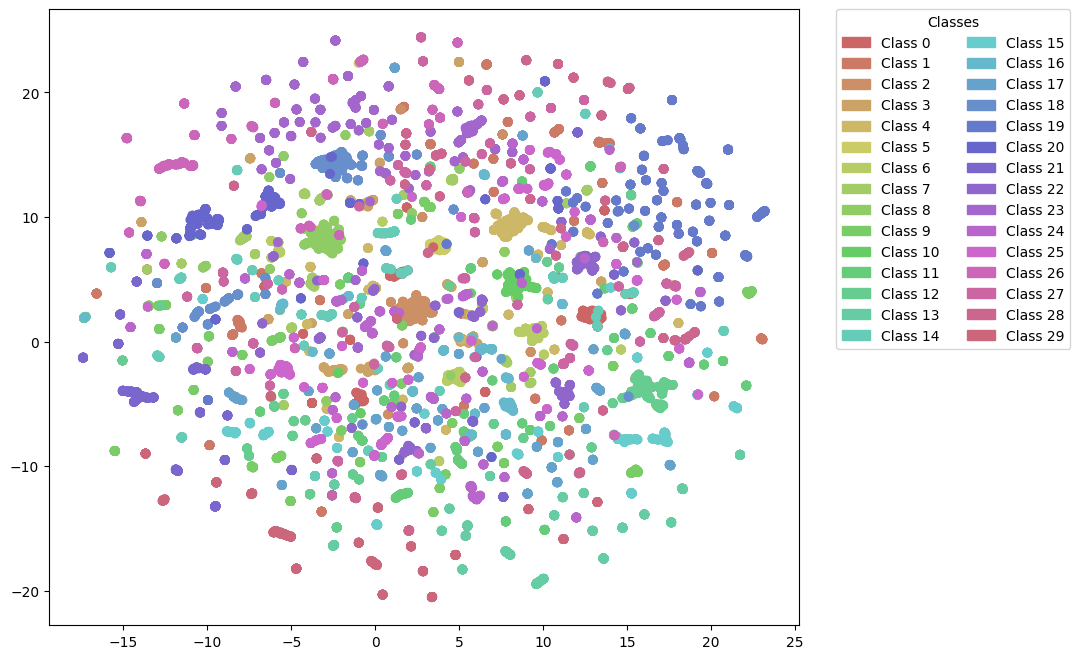

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(umap_X_train[:, 0], umap_X_train[:, 1], c= cl_res_emb_prompt_train, cmap=cmap_30)

# Für alle Klassen Patches erzeugen
patches = [mpatches.Patch(color=colors_30[i], label=f'Class {i}') for i in range(num_classes)]

# Legende mit allen Klassen (ggf. mehrspaltig, außerhalb rechts)
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Classes', ncol=2)

fig.subplots_adjust(right=0.75)

plt.show()

### [`Click here to go back to the Homepage`](../Homepage.md)